# Memory Information

In [1]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")
# keras-team /
# keras-contrib 

======================================== Memory Information ========================================
Total: 25.51GB
Available: 24.59GB
Used: 623.93MB
Percentage: 3.6%


# GPU Information

In [2]:
! nvidia-smi

Tue Nov 10 20:04:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers

     |████████████████████████████████| 1.3MB 2.8MB/s 
     |████████████████████████████████| 890kB 15.6MB/s 
     |████████████████████████████████| 1.1MB 19.8MB/s 
     |████████████████████████████████| 2.9MB 25.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=0aaa67649c121060cbb19621c01d5016494de53577d331a4f07581274d47f1a0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import numpy as np
import pandas as pd
import csv
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import ast
import random
import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
train_file = 'train.csv'
val_file = 'val.csv'

In [6]:
train_data = pd.read_csv(train_file, header=0, index_col=0)
val_data = pd.read_csv(val_file, header=0, index_col=0)

In [7]:
print(train_data.shape)
train_data.head()

(5727, 3)


,Post,Labels Set,Filtered_Post
Unique ID,,,
1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,"hate,offensive",मेरे देश हिन्दु निराले है। पक्के राम भक्त बाबर...
2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,non-hostile,सरकार हमेशा किसानों कमाई बढ़ाने नई-नई स्कीमें ...
3,"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील...",non-hostile,"सुशांत बिजनेस डील 9 जून थी, वो डील दीपेश सुशां..."
4,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं...,"defamation,offensive",@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं...
5,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स...,non-hostile,#unlock4guidelines - अनलॉक-4 गाइडलाइन्स जारी -...


In [8]:
print(val_data.shape)
val_data.head()

(811, 3)


,Post,Labels Set,Filtered_Post
Unique ID,,,
1,दृढ़ इच्छा शक्ति से परिपूर्ण प्रणबदा के लिए दे...,non-hostile,दृढ़ इच्छा शक्ति परिपूर्ण प्रणबदा देशहित सर्वो...
2,भारतीय जनता पार्टी rss वाले इतने गिरे हुए हैं ...,defamation,भारतीय जनता पार्टी rss इतने गिरे हूं मेरी जासू...
3,कोरोना से निपटने की तैयारी / दिल्ली में 10 हजा...,non-hostile,कोरोना निपटने तैयारी / दिल्ली 10 हजार बेड वाला...
4,गवर्नर कॉन्फ्रेंस में PM मोदी बोले- शिक्षा नीत...,non-hostile,गवर्नर कॉन्फ्रेंस PM मोदी बोले- शिक्षा नीति सर...
5,"यूपी: गाजीपुर में Toilet घोटाला, प्रधान व सचिव...",non-hostile,"यूपी: गाजीपुर Toilet घोटाला, प्रधान सचिव लाखों..."


In [9]:
labels_set = {'defamation',
 'fake',
 'hate',
 'non-hostile',
 'offensive'}

labels_mapping = {'defamation':0,
 'fake':1,
 'hate':2,
 'non-hostile':3,
 'offensive':4}

In [10]:
train_y = np.empty((0, 5))
for index, row in train_data.iterrows():
  y = np.zeros((1, 5))
  for label in row['Labels Set'].split(','):
    y[0, labels_mapping[label]] = 1

  train_y = np.vstack((train_y, y))


val_y = np.empty((0, 5))
for index, row in val_data.iterrows():
  y = np.zeros((1, 5))
  for label in row['Labels Set'].split(','):
    y[0, labels_mapping[label]] = 1

  val_y = np.vstack((val_y, y))




In [11]:
print(train_y.shape)
print(val_y.shape)

(5727, 5)
(811, 5)


In [12]:
def evaluation(y_true, y_pred):
  print("Fine Grained Accuracy = {}".format(accuracy_score(y_true, y_pred)))
  print("\n\nFine Grained Metrics\n")
  print(classification_report(y_true, y_pred))

  # y_true_coarse = np.zeros((y_true.shape[0], 2))
  # y_pred_coarse = np.zeros((y_true.shape[0], 2))

  # y_true_coarse_1 = y_true[:,3] 
  # y_true_coarse_0 = 1 - y_true_coarse[:,1]
  # y_true_coarse = np.hstack((y_true_coarse_0, y_true_coarse_1))
  
  # y_pred_coarse_1 = y_pred[:,3]
  # y_pred_coarse_0 = 1- y_pred_coarse[:,1]
  # y_pred_coarse = np.hstack((y_pred_coarse_0, y_pred_coarse_1))

  # print("Coarse Grained Accuracy = {}".format(accuracy_score(y_true_coarse, y_pred_coarse)))
  # print("\n\nCoarse Grained Metrics\n")
  # print(classification_report(y_true_coarse, y_pred_coarse))



## Indic Bert

In [13]:
MODEL_NAME = 'verloop/Hinglish-Bert'

In [14]:
# Use a GPU if you have one available (Runtime -> Change runtime type -> GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds for reproducibility
random.seed(26)
np.random.seed(26)
torch.manual_seed(26)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) 

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device) # Send the model to the GPU if we have one

# learning_rate = 1e-5
# optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)



Some weights of the model checkpoint at verloop/Hinglish-Bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at verloop/Hinglish-Bert a

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [15]:
# tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)#, do_lower_case=True)
# model = BertForSequenceClassification.from_pretrained(
#     MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.   
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )
# # model.cuda()

In [16]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [17]:
batch_size = 32
max_length = 256

### Train data loading

In [18]:
def X_process(sentences):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_length,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    return input_ids, attention_masks


In [19]:
def train_load(input_ids, attention_masks, labels):
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    train_dataset = TensorDataset(input_ids, attention_masks, labels)
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )
    return train_dataloader

In [20]:
def val_load(input_ids, attention_masks, labels):
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    val_dataset = TensorDataset(input_ids, attention_masks, labels)
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    
    return validation_dataloader

In [21]:
def train_fn(train_dataloader, validation_dataloader):
    
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()
    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            loss, logits = model(b_input_ids, 
                                 token_type_ids=None, 
                                 attention_mask=b_input_mask, 
                                 labels=b_labels)

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        
        y_pred = []

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                (loss, logits) = model(b_input_ids, 
                                       token_type_ids=None, 
                                       attention_mask=b_input_mask,
                                       labels=b_labels)

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            
#             labels = label_ids
            preds = logits
            pred_flat = np.argmax(preds, axis=1).flatten()
#             labels_flat = labels.flatten()
#             y_true.extend(labels_flat)
            y_pred.extend(pred_flat)


        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
        print(training_stats)
        
    return training_stats, y_pred


In [22]:
def stats(training_stats):
    pd.set_option('precision', 2)

    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)

    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')

    # A hack to force the column headers to wrap.
    #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

    # Display the table.
    return df_stats


In [23]:
def plot_stats(df_stats):
    sns.set(style='darkgrid')

# Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks([1, 2, 3, 4])

    plt.show()


In [24]:
y_train_offensive = train_y[:,4].astype(int)
y_val_offensive = val_y[:,4].astype(int)

In [25]:
train_sentences = train_data['Filtered_Post'].values
val_sentences = val_data['Filtered_Post'].values


# train_sentences = train_data['Post'].values
# val_sentences = val_data['Post'].values

In [26]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [27]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


### Offensive

In [28]:
train_labels_offensive = y_train_offensive

In [29]:

val_labels_offensive = y_val_offensive

In [30]:
input_ids, attention_masks = X_process(train_sentences)
train_dataloader = train_load(input_ids, attention_masks, train_labels_offensive)

input_ids, attention_masks = X_process(val_sentences)
validation_dataloader = val_load(input_ids, attention_masks, val_labels_offensive)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [31]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [32]:
training_stats, y_pred_offensive = train_fn(train_dataloader, validation_dataloader)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    179.    Elapsed: 0:00:31.
  Batch    80  of    179.    Elapsed: 0:01:02.
  Batch   120  of    179.    Elapsed: 0:01:33.
  Batch   160  of    179.    Elapsed: 0:02:04.

  Average training loss: 0.32
  Training epcoh took: 0:02:19

Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.26
  Validation took: 0:00:06
[{'epoch': 1, 'Training Loss': 0.31651270066975884, 'Valid. Loss': 0.25854639537059343, 'Valid. Accur.': 0.8871284965034966, 'Training Time': '0:02:19', 'Validation Time': '0:00:06'}]

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    179.    Elapsed: 0:00:31.
  Batch    80  of    179.    Elapsed: 0:01:02.
  Batch   120  of    179.    Elapsed: 0:01:33.
  Batch   160  of    179.    Elapsed: 0:02:04.

  Average training loss: 0.24
  Training epcoh took: 0:02:19

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.24
  Validation took: 0:00:06
[{'epoch': 1, 'Training Loss': 0.316512700669758

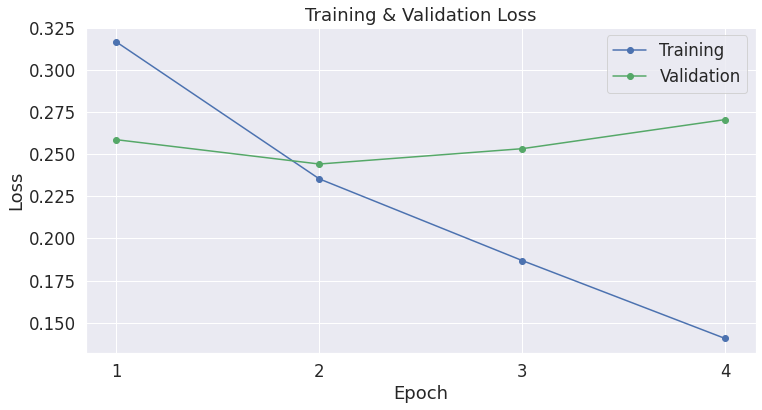

In [33]:
df_stats  = stats(training_stats)
plot_stats(df_stats)

In [34]:
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.32,0.26,0.89,0:02:19,0:00:06
2,0.24,0.24,0.88,0:02:19,0:00:06
3,0.19,0.25,0.89,0:02:19,0:00:06
4,0.14,0.27,0.89,0:02:19,0:00:06


In [35]:
evaluation(y_val_offensive, y_pred_offensive)

Fine Grained Accuracy = 0.8927250308261405


Fine Grained Metrics

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       708
           1       0.58      0.56      0.57       103

    accuracy                           0.89       811
   macro avg       0.76      0.75      0.76       811
weighted avg       0.89      0.89      0.89       811



In [36]:
np.savetxt("y_pred_offensive.csv", y_pred_offensive, delimiter =",", fmt ='% s')